# Group sizes

Get all unique size labels from the database.

In [98]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import entropy
from tabulate import tabulate
from pymongo import MongoClient
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20,8)


db = MongoClient()['stores']

TOTAL_NUMBER_OF_PRODUCTS = db.data.count()

results = db.data.aggregate(
    [
        {
            "$group": {
                "_id": "$size",
                "count": {"$sum": 1},
            }
        },
        {
            "$sort": {
                "count": -1,
            }
        }
    ]
)

ALL_SIZES = [(str(x['_id']), x['count']) for x in list(results)]
print('Number of uniq. sizes: {}'.format(len(ALL_SIZES)))

Number of uniq. sizes: 1117


## Sizes per distributor

Distributor      Number of uniq. Sizes
-------------  -----------------------
jeneva                             491
shemeka                            286
marsha                             222
kina                               189
rubi                               186
larry                              107
ignacia                            106
wendell                             94
patti                               81
denisha                             74
evie                                64
allegra                             64
major                               63
titus                               50
carey                               35
ciara                               30
yolande                             28
rossana                             27
joanie                              17
zack                                14


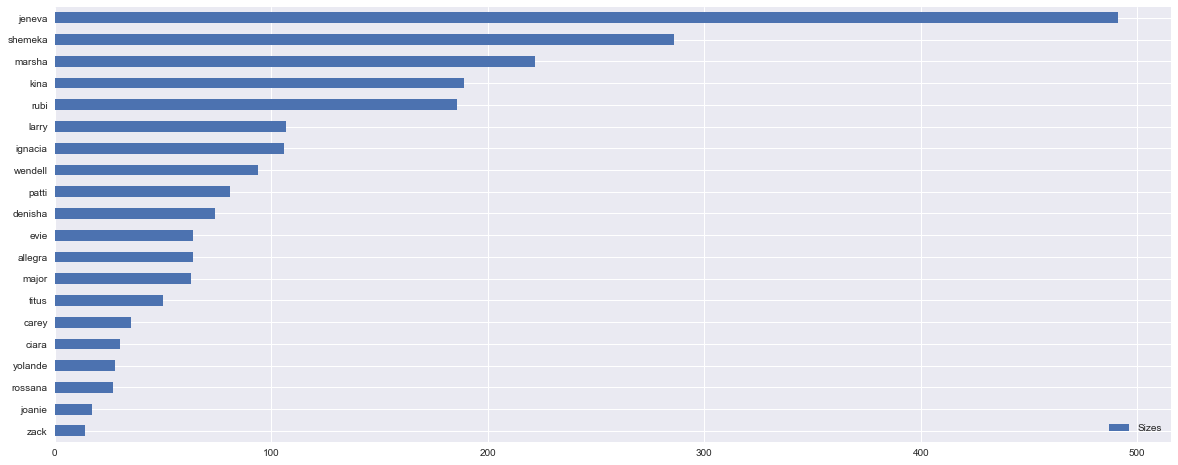

In [99]:
DISTRIBUTORS = list(db.data.distinct("source"))
results = db.data.aggregate(
    [
        {
            "$group": {
                "_id": "$source",
                "sizes": {"$addToSet": "$size"},
            }
        },
        {
            "$project": {
                "_id": 1,
                "count": {"$size": "$sizes"}
            }
        },
        {
            "$sort": {
                "count": -1,
            }
        }
    ]
)
SIZES_PER_DISTRIBUTOR = [
    (str(x['_id']), x['count']) 
    for x in list(results)
]
print(tabulate(SIZES_PER_DISTRIBUTOR, 
               headers=['Distributor', 'Number of uniq. Sizes'], 
               tablefmt="simple"))

df_values_by_key = pd.DataFrame(SIZES_PER_DISTRIBUTOR, 
                                index=[x[0] for x in SIZES_PER_DISTRIBUTOR], 
                                columns=['Distributor', 'Sizes'])
df_values_by_key.iloc[::-1].plot.barh()

Print joint table with first 60 sizes.

In [100]:
import operator

all_sizes_table = []
number_of_sizes = 180
for sizes in zip(ALL_SIZES[0:number_of_sizes:3],
                 ALL_SIZES[1:number_of_sizes:3],
                 ALL_SIZES[2:number_of_sizes:3]):
    all_sizes_table.append(list(reduce(operator.add, sizes)))

print(
    tabulate(
        all_sizes_table[:60], 
        headers=3*['Size', 'Number of Products'], 
        tablefmt="simple"))

Size          Number of Products  Size         Number of Products  Size        Number of Products
----------  --------------------  ---------  --------------------  --------  --------------------
M                         202965  L                        202641  S                       202589
XL                        186166  2XL                      152014  3XL                     106966
XS                         71104  4XL                       50869  MEDIUM                   31645
LARGE                      31599  SMALL                     31506  EXTRA                    31098
2X                         20091  3X                        20085  5XL                      17541
ONE                        13786  XXL                       11288  OS                        7615
ONE SIZE                    7269  XX                         7184  6XL                       6993
4X                          6945  ALL                        4087  L/XL                      3901
XLT                 

## Calculate entropy

In [101]:
# calculate probability vector
p = [x[1] for x in ALL_SIZES]
size_prob_vector = np.array(p) / TOTAL_NUMBER_OF_PRODUCTS

# calculate entropy
first_entropy = entropy(size_prob_vector)

print("Data entropy:", first_entropy)

Data entropy: 3.07781166841


## Create new collection from data only with '_id', 'source' and 'size' fields

In [49]:
# create new collection
db.data.aggregate(
    [
        {
            "$project": {
                "_id": 1,
                "source": 1,
                "size": 1,
            },
        },
        {
            "$out": "size_mapping"
        }
        
    ]
)
print('Db "size_mapping" created')

# create indexes
db.size_mapping.create_index([("size", 1)])
db.size_mapping.create_index([("source", 1)])
print('Indexes "size", "source" for "size_mapping" created.')

print(list(db.size_mapping.find().limit(5)))


[{'_id': ObjectId('55fedba0c702283c66874a04'), 'source': 'shemeka', 'size': 'ONE'}, {'_id': ObjectId('55fedba0c702283c66874a05'), 'source': 'shemeka', 'size': 'ONE'}, {'_id': ObjectId('55fedba0c702283c66874a07'), 'source': 'shemeka', 'size': 'ONE'}, {'_id': ObjectId('55fedba0c702283c66874a08'), 'source': 'shemeka', 'size': 'ONE'}, {'_id': ObjectId('55fedba1c702283c66874a0a'), 'source': 'shemeka', 'size': 'M'}]


## Sizes list per distributor

In [102]:
SIZES_LIST_PER_DISTRIBUTOR = db.size_mapping.aggregate(
    [
        {
            "$group": {
                "_id": "$source",
                "sizes": {"$addToSet": "$size"},
            },
        },
        {
            "$project": {
                "_id": 1,
                "sizes": 1,
                "number_of_sizes": {"$size": "$sizes"},
            }
        },
        {
            "$sort": {
                "number_of_sizes": -1
            }
        }
        
    ]
)

TABLE_SIZES_LIST_PER_DISTRIBUTOR = [
    (str(x['_id']), x['sizes'], x['number_of_sizes']) 
    for x in SIZES_LIST_PER_DISTRIBUTOR
]

In [103]:
for distr, sizes, num in TABLE_SIZES_LIST_PER_DISTRIBUTOR:
    print('Sizes for: "{}"'.format(distr))
    print(", ".join(sizes))
    print(80*"-")

Sizes for: "jeneva"
4XLT, L-XL, 28UL, XL-18/20, L-14/16, 50X30, 56UL, 58UL, 52UL, 50UL, 48UL, 46UL, 3330, 3836, 40UL, 3636, 3436, 3334, 3132, 29X30, 28X30, 31X32, 29 UL, 46 UL, 50 UL, 48 UL, 40 UL, 42 UL, 34 UL, 33 UL, 32 UL, 40 UU, 38 UU, 36 UU, 34 UU, 44 UL, 30 36, 48X34, 32XUU, 38XUU, 36XUU, 34XUU, 30XUU, 5630, 6032, 6030, 5832, 5632, 5232, 5230, 5032, 5030, 4830, 19.5 REG, 15.5 REG, 16.5 REG, 17.5 REG, 2XXT, 4432, 3032, 3030, 12S, 8H, 10S, LXT, 40X30, 5SL, 14SL, 8SL, 7SL, 54, 20.5, 18.5, 16.5, 21, 4234, 4XL, 4232, 4030, 3834, 3832, 3634, 42, 6SL, 14H, 3432, S-7/8, 3630, 3232, 28XUL, 34 28, 29XUL, 5XR, 4632, 2XS, 3-6 MTH, 4XT, 4XR, 34 32, 3XT, XLR, 36, 11, 5430, 18.5 REG, 3XR, 2XR, 33X34, 2XT, 54UL, 24W, 9-11, 34 31, XXS/XS, 7-9, 3XLT, 34 29, 15, 19, 6/8, 33X32, 50XUU, 52XUU, 54XUU, 46X34, 46X32, 2T, 46X30, 44XUU, 42XUU, 40XUU, XLS, 4032, 31 31, 5S, 56XUU, 38XUL, 4430, 32XUL, 30XUL, EACH, 44X30, 42 29, 12H, 56, 10H, XXL, UNDERTAPE/IN HOUSE, 20H, 32 36, RIP-N-ZIP, 18-24 MTH, 12SL, 32

## Tagging according to size

Since the number of sizes is low (1117 uniq sizes), the task could be resolved using tivial brute force, i.e. map sizes using mapping table.

During the observation of data i noticed that sizes are defined for adult, youth, toddler and baby:

- Adult: 'S', 'M', 'L' etc.
- Youth: 'YS', 'YL' etc.
- Kid: '4', '6' etc.
- Toddler: '2T', '3T' etc. 
- Baby: '3M', '6M', 'NB' (new born) etc.

[kid, toddler, baby sizes chart](http://www.carters.com/cs-sizing.html)
[youth sizes chart](https://www.underarmour.com/en-us/size-charts)

I.e. could tag products accodring to the size.

```python
TAG_FROM_SIZE = {
    'adult': ['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL', '4XL', '5XL', '6XL'],
    'youth': ['YXS', 'YSM', 'YMD', 'YLG', 'YXL', '8H', '10H', '12H', '14H', '16H', '18H', '20H'],
    'kid': []
}
```

In [50]:
SIZES_MAPPING = {
    'ALL': [],
    'NO SIZE': ['PLAIN', 'CONE', 'BLANKET'],
    'ONE': ['OS', 'ONE SIZE', '1 SIZ', 'O/S'],
    'XS': ['XXS', 'XX-SMALL', '2XS'],
    'S': ['SMALL', 'S/M'],
    'M': ['MEDIUM', 'S/M', 'M/L'],
    'L': ['LARGE', 'L/XL', 'M/L'],
    'XL': ['EXTRA', 'XLT', 'XT', 'L/XL'],
    '2XL': ['2X', 'XXL', '2XT', '2XLL', '2X/', '2XLT'],
    '3XL': ['3X', '3XT', '3XLL', '3XLT'],
    '4XL': ['4X', '4XT', '4XLT'],
    '5XL': ['5X', '5XT', '5XLT'],
    '6XL': ['6X'],
}

def build_matching_table(matching_rules):
    """Build matching table from matching rules

    :param matching_rules: matching rules used to build matching table
    :type matching_rules: dict
    :return: matching table `{'S/M: ['S', 'M'], '2X': ['2XL'], ...}`
    :rtype: dict
    """
    matching_table = {}
    # transform matching rules to the "shortcut": "group_key" table
    for key, values in matching_rules.items():
        if not values:  # skip undefined rules i.e. "[]"
            continue

        # add rule for key
        if key not in matching_table:
            # NOTE: set('ab') would be {'a', 'b'}
            # so it's impossible to matching_table[key] = set(key)
            matching_table[key] = set()
            matching_table[key].add(key)
            
        for value in values:
            if value not in matching_table:
                matching_table[value] = set()
                matching_table[value].add(key)
            else:
                matching_table[value].add(key)
    return matching_table

 
MATCHING_RULES = build_matching_table(SIZES_MAPPING)
print(tabulate(MATCHING_TABLE.items(), headers=['From', 'To'], tablefmt="simple"))

From      To
--------  -----------
6X        {'6XL'}
MEDIUM    {'M'}
6XL       {'6XL'}
NO SIZE   {'NO SIZE'}
XLT       {'XL'}
XXS       {'XS'}
L         {'L'}
L/XL      {'L', 'XL'}
2XL       {'2XL'}
3XL       {'3XL'}
4XT       {'4XL'}
BLANKET   {'NO SIZE'}
XL        {'XL'}
4XL       {'4XL'}
5X        {'5XL'}
4XLT      {'4XL'}
M/L       {'M', 'L'}
5XLT      {'5XL'}
S         {'S'}
XX-SMALL  {'XS'}
S/M       {'S', 'M'}
XXL       {'2XL'}
PLAIN     {'NO SIZE'}
3XT       {'3XL'}
5XT       {'5XL'}
5XL       {'5XL'}
EXTRA     {'XL'}
3X        {'3XL'}
2XLT      {'2XL'}
SMALL     {'S'}
3XLL      {'3XL'}
ONE       {'ONE'}
2XS       {'XS'}
XT        {'XL'}
OS        {'ONE'}
3XLT      {'3XL'}
2XLL      {'2XL'}
4X        {'4XL'}
ONE SIZE  {'ONE'}
XS        {'XS'}
2X        {'2XL'}
2XT       {'2XL'}
1 SIZ     {'ONE'}
M         {'M'}
2X/       {'2XL'}
CONE      {'NO SIZE'}
LARGE     {'L'}


In [ ]:
# process data into the new table
# def get_groups(mtable, size):
#     """Get size groups for the given `size` according to matching table

#     :param size: size (case insensetive)
#     :type size: str
#     :return: list of strings i.e. size groups or ``['UNDEFINED']``
#     if not found
#     :rtype: list or ['UNDEFINED']
#     """
#     return list(mtable.get(size, default=size))


# for k, v in MATCHING_TABLE.items():
#     res = db.size_mapping.update_many(
#         {"size": k}, 
#         {"$set": {"size": get_groups(MATCHING_TABLE, k)}})
#     print(res.raw_result)

Let's calculate data entropy for results

In [27]:
results = db.size_mapping.aggregate(
    [
        {
            "$group": {
                "_id": "$size",
                "count": {"$sum": 1},
            }
        },
        {
            "$sort": {
                "count": -1,
            }
        }
    ]
)

NEW_SIZES = [(str(x['_id']), x['count']) for x in list(results)]

print(
    "\n" + 
    tabulate(NEW_SIZES[:20], headers=['Size', 'Number of Products'], tablefmt="orgtbl") +
    "\n"
)

# calculate probability vector
p = []
for _, count in NEW_SIZES:
    p.append(count)
size_prob_vector = np.array(p) / TOTAL_NUMBER_OF_PRODUCTS

# calculate entropy
first_entropy = entropy(size_prob_vector)

print("Data entropy: ", first_entropy)


| Size    |   Number of Products |
|---------+----------------------|
| ['M']   |               238640 |
| ['L']   |               234240 |
| ['S']   |               234095 |
| ['XL']  |               225167 |
| ['2XL'] |               187326 |
| ['3XL'] |               130454 |
| ['XS']  |                73671 |
| ['4XL'] |                60609 |
| ['ONE'] |                29188 |
| ['5XL'] |                20189 |
| ['6XL'] |                 7787 |
| XX      |                 7184 |
| ALL     |                 4087 |
| OSFA    |                 3687 |
| LT      |                 3355 |
| YL      |                 2341 |
| YM      |                 2305 |
| YS      |                 2304 |
| 4T      |                 2185 |
| 2T      |                 2145 |

Data entropy:  2.61658173526


In [36]:
from functools import reduce

total_matched_products = (sum([x[1] for x in NEW_SIZES[:11]]))
percent_from_db_total = round((total_matched_products / TOTAL_NUMBER_OF_PRODUCTS) * 100, 2)

print("Matched: {} Percent from total: {}".format(total_matched_products, percent_from_db_total))

Matched: 1441366 Percent from total: 92.33
